<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#About-this-document" data-toc-modified-id="About-this-document-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>About this document</a></span></li><li><span><a href="#Application-Background" data-toc-modified-id="Application-Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Application Background</a></span><ul class="toc-item"><li><span><a href="#Data-Cube-Statistics-Tools" data-toc-modified-id="Data-Cube-Statistics-Tools-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Cube Statistics Tools</a></span><ul class="toc-item"><li><span><a href="#Main-Features" data-toc-modified-id="Main-Features-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Main Features</a></span></li><li><span><a href="#Usage" data-toc-modified-id="Usage-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Usage</a></span></li><li><span><a href="#Available-Statistics" data-toc-modified-id="Available-Statistics-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Available Statistics</a></span></li></ul></li><li><span><a href="#How-to-run-the-program" data-toc-modified-id="How-to-run-the-program-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>How to run the program</a></span></li></ul></li><li><span><a href="#Interactive-execution-on-Raijin-and-VDI" data-toc-modified-id="Interactive-execution-on-Raijin-and-VDI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Interactive execution on Raijin and VDI</a></span><ul class="toc-item"><li><span><a href="#Configuration-file" data-toc-modified-id="Configuration-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Configuration file</a></span><ul class="toc-item"><li><span><a href="#working_example_1.yaml" data-toc-modified-id="working_example_1.yaml-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>working_example_1.yaml</a></span></li><li><span><a href="#Description-of-parameters" data-toc-modified-id="Description-of-parameters-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Description of parameters</a></span></li></ul></li><li><span><a href="#Commandline-Parameters" data-toc-modified-id="Commandline-Parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Commandline Parameters</a></span></li></ul></li><li><span><a href="#Batch-job-on-PBS-queue" data-toc-modified-id="Batch-job-on-PBS-queue-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Batch job on PBS queue</a></span></li><li><span><a href="#Visualisation-of-the-output" data-toc-modified-id="Visualisation-of-the-output-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualisation of the output</a></span><ul class="toc-item"><li><span><a href="#QGIS-(Quantum-Geographic-Information-System)" data-toc-modified-id="QGIS-(Quantum-Geographic-Information-System)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>QGIS (Quantum Geographic Information System)</a></span></li><li><span><a href="#Panoply---netCDF-visualisation-software-from-NASA" data-toc-modified-id="Panoply---netCDF-visualisation-software-from-NASA-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Panoply - netCDF visualisation software from NASA</a></span></li><li><span><a href="#Ncview:-a-netCDF-visual-browser-from-Scripps-Institution-of-Oceanography" data-toc-modified-id="Ncview:-a-netCDF-visual-browser-from-Scripps-Institution-of-Oceanography-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Ncview: a netCDF visual browser from Scripps Institution of Oceanography</a></span></li></ul></li><li><span><a href="#Interactive-API-execution-on-Jupyter-notebook" data-toc-modified-id="Interactive-API-execution-on-Jupyter-notebook-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Interactive API execution on Jupyter notebook</a></span><ul class="toc-item"><li><span><a href="#Import-the-standard-modules" data-toc-modified-id="Import-the-standard-modules-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Import the standard modules</a></span></li><li><span><a href="#Import-a-local-module" data-toc-modified-id="Import-a-local-module-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Import a local module</a></span></li><li><span><a href="#Define-a-local-function" data-toc-modified-id="Define-a-local-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Define a local function</a></span></li><li><span><a href="#Configuration-File" data-toc-modified-id="Configuration-File-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Configuration File</a></span></li><li><span><a href="#Create-and-load-the-config" data-toc-modified-id="Create-and-load-the-config-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Create and load the config</a></span></li><li><span><a href="#Define-the-datacube-stats-application" data-toc-modified-id="Define-the-datacube-stats-application-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Define the datacube stats application</a></span></li><li><span><a href="#Generate-the-tasks-and-get-the-results" data-toc-modified-id="Generate-the-tasks-and-get-the-results-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>Generate the tasks and get the results</a></span></li><li><span><a href="#Run-the-tasks" data-toc-modified-id="Run-the-tasks-6.8"><span class="toc-item-num">6.8&nbsp;&nbsp;</span>Run the tasks</a></span></li><li><span><a href="#Collect-the-data-for-plotting" data-toc-modified-id="Collect-the-data-for-plotting-6.9"><span class="toc-item-num">6.9&nbsp;&nbsp;</span>Collect the data for plotting</a></span></li><li><span><a href="#Plot-it-as-three-bands-combined-image" data-toc-modified-id="Plot-it-as-three-bands-combined-image-6.10"><span class="toc-item-num">6.10&nbsp;&nbsp;</span>Plot it as three bands combined image</a></span></li></ul></li></ul></div>

# Getting Started with Datacube Stats
| Author(s):  | [Arapaut Sivaprasad](mailto:Sivaprasad.Arapaut@ga.gov.au)|
|----------|----------------|
| Created: | May 17, 2018 |
| Last edited: | Jun 01, 2018 |
| Acknowledgements: | Imam Alam|

## About this document

**Background**

Data Cube Statistics is a an application to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

**What does this document do?**

This document is a startup guide to using the 'document-stats' program to analyse continental scale statistics over a 30+ year time range. It aims to get you started using the program, with basic examples and statistical analyses.

The program is intended to be run from commandline, or as a queue job, on Raijin. It takes several minutes to several hours to complete the job. However, in order to understand the usage and to see the output in a visual manner, this document will show an interactive session to analyse just one scene or "tile", which takes only a few seconds. Detailed instructions to run the program on Raijin interactively and through queue jobs will also be given.

A basic understanding of the PSB job scheduler on Raijin is advantageous, but not essential. You must have, as expected to be, an account on Raijin with memebership in at least one project. Please verify with your supervisor about which project to use and how much resources are allocated to your research. The costs will vary depending on the type of PBS queue used as well as the complexity and size of the job.

**How to use this document**

There are five sections that describe the software and its usage. You can skip any section by clicking its heading line.

1. Backgound information about the software and its inputs and outputs.
2. Run interactively in a Unix shell and and monitor the progress.
3. Submit to a PBS job queue and monitor the progress.
4. Visualise the outputs.
5. Run interactively through Jupyter notebook and plot the output.


## Application Background


### Data Cube Statistics Tools
Data Cube Statistics is an application to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

#### Main Features

- Calculates continental scale statistics over a 30+ year time range.
- Simple yet powerful configuration format.
- Scripts supplied for running in a HPC, PBS-based environment.
- Flexible tiling and chunking for efficient execution of 100+TB jobs.
- Track and store full provenance record of operations.
- Round-trip workflow from ODC back into ODC.
- Supports saving to NetCDF, GeoTIFF or other GDAL supported formats.
- Optional per-pixel metadata tracking.
- Out of the box support for most common statistics.
- Able to create user defined custom statistics.
- Able to handle any CRS and resolution combination.

#### Usage
This is a commandline-driven program and all configurations are specified in a YAML file. The simplest way to execute it is as below.

> **$ datacube-stats example-configuration.yaml**

#### Available Statistics
Type in the following commandline to get a list of all statistical methods that are implemented.

> **$ datacube-stats --list-statistics**

|Available Statistical Methods||
|--|--|
| simple | percentile | percentile_no_prov | 
| medoid | medoid_no_prov | medoid_simple | 
| simple_normalised_difference | wofs_summary | tcwbg_summary | 
| masked_multi_count | external | wofs-summary | 
| geomedian |



### How to run the program

There are three ways to run the program, depending upon how large or complex the tasks are, how soon you want the result and how much cost can be incurred.

- **Serial mode:** A single process to go through all tasks in a sequential manner.

- **Parallel mode:** Multiple processes are created, each handling one task. If there are more tasks than processes, a process that finishes a task will take on another.

- **Batch mode:** Submitting to a PBS queue on Raijin. A batch job runs in parallel, unless specified otherwise.


## Interactive execution on Raijin and VDI

This program is meant to be run as a batch job, since it may take several minutes to hours to complete. However, when the date range is small, you may want to execute it interactively and get results quickly. A commandline execution is possible in this situation.

To run in commandline mode, you can issue the following minimal commands at a shell prompt.

> **`datacube-stats config.yaml`**

> **`datacube-stats --parellel 16 config.yaml`**


**INTERACTIVE, PARALLEL EXECUTION IS ERROR-PRONE DUE TO SOME UNIDENTIFIED MEMORY ISSUE(S) IN THE PROGRAM. IT IS THEREFORE ADVISED TO USE ONLY THE BATCH MODE WHEN THE DATA IS LARGE.** 

See **this document** if you wish to learn more about interactive, serial and parallel executions.


### Configuration file
Apart form some specific commandline options, all parameters to the program can be supplied through a configuration file, which is in YAML format.  An example config file is given below.

A simple example to load and analyse all scenes for a date range is given in the example YAML file below. It can be run by the following commandline switches:

- **datacube-stats working_example_1.yaml:** To create an output file for each of the tiles. The date range below results in **89** tiles.

- **datacube-stats --tile-index 15 -40 working_example_1.yaml:** Create just one output file for the specified tile.

#### working_example_1.yaml
    sources:
      - product: ls8_nbar_albers
        measurements: [blue, green, red, nir, swir1, swir2]
        group_by: solar_day

    date_ranges:
      start_date: 2017-01-01
      end_date: 2017-01-02

    location: /tmp

    storage:
      driver: NetCDF CF
      crs: EPSG:3577
      tile_size:
          x: 100000.0
          y: 100000.0
      resolution:
          x: 25
          y: -25
      chunking:
          x: 200
          y: 200
          time: 1
      dimension_order: [time, y, x]

    output_products:
     - name: landsat_seasonal_mean
       product_type: seasonal_stats
       statistic: simple
       statistic_args:
         reduction_function: mean
       output_params:
         zlib: True
         fletcher32: True
       file_path_template: 'SR_N_MEAN/SR_N_MEAN_3577_{x:02d}_{y:02d}_{epoch_start:%Y%m%d}.nc'

#### Description of parameters
Short descriptions of the params are given here. See [here](https://github.com/GeoscienceAustralia/datacube-stats/#configuration-format) for details and examples.

- **sources:** The products, e.g. ls8_nbar_albers

    - measurements: The bands. e.g. [blue, green, red]
    
    - group_by: solar_day
    
    - source_filter: 
          
         - product: ls5_level1_scene
          
         - gqa_iterative_mean_xy: [0, 1]
              
              - Do not consider the datasets that were derived from some `ls5_level1_scene` that had a particularly bad GQA (Geometric Quality Assessment) 
    
    - masks: Apply the Pixel Quality masks. See [this document](http://geoscienceaustralia.github.io/digitalearthau/notebooks/DEA_datasets/Landsat5-7-8-PQ.html) for details.
    
- **date_ranges:** Date ranges for the data. Each tile may have several "time slices" based on the date range.

- **input_region:** Latitude/Longitude co-ordinates, specified either as numbers  (as below) or as in a [shape file](http://geojson.io/#map=2/20.0/0.0).

   - longitude: [149.05, 149.17]
   
   - latitude: [-35.25, -35.35]

- **computation:** Each tile has 4000 x 4000 pixels. Split them into smaller chunks for calculation. Too small value (say, 200) will take very long time to finish, whereas larger than 1000 will consume too much RAM.
      
     - chunking:
        
       - x: 1000
        
       - y: 1000
       
- **location:** Directory for output files, e.g. /g/data/u46/users/sa9525/avs. Make sure that it is on a drive with sufficient quota for your user ID. Trying it on /tmp will not work, as it has only a quota of 100MB. Also, avoid the /short directory if you intend to keep the output files for long term storage (> 365 days).

- **storage:** The output file format
  
  - driver: NetCDF CF: Create files in NetCDF format (\*.nc). These can be viewed with Panoply, ncview and QGIS.
  - driver: GeoTiff: Create files in TIFF format (\*.tif). These can be viewed with QGIS.

  - crs: EPSG:3577: Geographical Spatial References. EPSG:3577 = Australia-wide
  
  - tile_size: Dimensions of tiles in meters.

      - x: 100000.0
      
      - y: 100000.0
      
  - resolution: Pixel dimensions in meters.
      - x: 25
      
      - y: -25
      
  - chunking: Chunk sizes for writing the output
      
      - x: 200
      
      - y: 200
      
      - time: 1
      
      - **NOTE:** If using `GeoTiff` as the driver, the `x` and `y` values must both be 256

- **dimension_order:** [time, y, x]: Each tile is processed layer by layer based on time slices.

- **output_products:** Specifications of the statistical method to be used, and the output file path.
     
     - name: landsat_seasonal_mean
       
     - product_type: seasonal_stats
       
     - statistic: simple
   
     - statistic_args:
     
         - reduction_function: mean
   
   - output_params:
     
     - zlib: True
     
     - fletcher32: True
     
   - file_path_template: 'SR_N_MEAN/SR_N_MEAN_3577_{x:02d}_{y:02d}_{epoch_start:%Y%m%d}.nc'
   
       - **NOTE:** If using `GeoTiff` as the driver, the filename must end as ***.tif***
       
    

### Commandline Parameters

The commandline switches, or parameters, act as further ways to modify the operation of the program. A list of these parameters and their short descriptions can be seen by the command, **datacube-stats --help**. Some additional details are given below.

| Parameter | Description | Additional Information |
|-|-|
| **--save-tasks PATH:** | Save the tasks in a file. | The program reads the datacube data and creates a set of tasks, which can be saved in a file to be used again. Useful only when using the same date range and input region.|
| **--load-tasks PATH:** | The saved tasks can be loaded with this command.| You can load parts of the tasks in any order |
| **--tile-index INTEGER...:** | Specify the IDs of tiles to be analysed. | e.g. tile "15 -40" covers a part of ACT.|
| **--tile-index-file PATH:** | Specify more than one tile, if any, in a file as one per line. | e.g. "15 -40 and 15 -41" to cover the whole of ACT. They need not be contiguous. |
| **--output-location TEXT:** | Override output location specified in configuration file.|
| **--year INTEGER:** | Override time period specified in configuration file.|
| **--task-slice SLICE:** | The subset of tasks to perform, using Python's slice syntax.| e.g. you can specify a sub-section of the tasks as [3:9] or [0:100:10], etc. |
| **--batch INTEGER:** | The number of batch jobs to launch using PBS and the serial executor.| The batch jobs can be automatically sent with the "---qsub" option or manually by the "--batch" option. In the latter case, it will not use the celery executor to farm out the tasks and, therefore, you have better control. |
| **--list-statistics:** | Display the different statistical method that have been implemented.|
| **--version:** | Display the program version.|
| **-v, --verbose:** | Show debugging lines. | Specify more then one 'v' to increase the levels of such lines. e.g. -vvv |
| **--log-file TEXT:** | Specify a log file.|
| **-C, --config, --config_file TEXT:**| This refers to the file that specifies which datacube is to be used | It is defined by the environment variable, DATACUBE_CONFIG_PATH, which is defined as */g/data/u46/users/sa9525/datacube.conf* in your '.bashrc'. You can specify a different file here.|
| **-E, --env TEXT:**| This specifies which section of the config file to use. | e.g. *--env dea-staging* will use the [dea-staging] in the config file. |
| **--log-queries:** | Print database queries.| Useful for debugging and development purposes. Not needed by the end user. |
| **--qsub OPTS:** | Launch via qsub, supply comma or new-line separated list of parameters. Try --qsub=help.| This option, without the '--batch' option will farm out, by using the celery executor, the tasks to multiple cores. |
| **--workers-per-node INTEGER:** | Specify the number of tasks allocated to each node. | Applicable only in the case of interactive parallel mode.|
| **--queue-size INTEGER:** | Overwrite defaults for queue size.|
| **--celery HOST:PORT:** | Use celery backend for parallel computation. | Supply redis server address, or "pbs-launch" to launch redis server and workers when running under pbs.|
| **--dask HOST:PORT:** | Use celery backend for parallel computation. | Supply redis server address, or "pbs-launch"to launch redis server and workers when running under pbs.|
| **--parallel INTEGER:** | Run locally in parallel mode using the specified number of cores.|




## Batch job on PBS queue

A batch job is one where a program is run on a queue that is detached from the interactive session. Unlike an interactive session, a batch job will write all output to a file instead of the terminal. Such file is not written until after the job finishes and, hence, it is not possible to follow the progress of a job (except by looking at the results files).

Use the following command to submit a **datacube-stats** job to the batch queue.

> **datacube-stats --qsub 'ncpus=16,walltime=8h,project=v10,queue=express,noask,mem=4G,name=Datacube-stats' batch.yaml**

> **datacube-stats --qsub 'nodes=1,walltime=8h,project=v10,queue=express,noask,mem=4G,name=Datacube-stats' batch.yaml**

where, 

- **--qsub:** Commandline parameter to run the program in batch mode.

- **que=express:** Use the express queue. 
    
- **walltime=8h:** Requesting 8 hours of continuous operation. 
    
    - The walltime must be enough to complete the job. Otherwise, it will get killed.
    
    - You can request more walltime than required. Only the amount actually used will be charged.

- **ncpus=16:** The number of CPUs (or cores) to be used. 
    
    - It will use as many CPUs as required.

    - Requesting more than 16 CPUs is OK for batch queue.
    
- **nodes=1** The number of nodes or physical machines to use. Each node has 16 cores and, hence, specifying that nodes=1 or ncpus=16 both mean the same, and only one needs to be there. 
   
- **mem:4G** Amount of RAM requested per core. Thus, in the above command, we are requesting 64GB.
    
    - You can request up to 8 GB per CPU, but should choose 4 GB or less to avoid getting rejected.   
    
- **project=v10:** The project ID number. 

- **noask:** The queue starts without further confirmation from you.
    
    - It is best to use this switch, as there may be a wait of several minutes before teh queue is allocated.
    
- **name=Datacube-stats:** An arbitrary name to be given to the queue.

    - This will be used in creating the outputs and queue statistics files.
    
    - It will also be used to report any error with the que.
    
- **batch.yaml:** The YAML file to run the datacube-stats program.    


Two files, *viz.,* **Job-ID.e\*** and **Job-ID.o\***, will be created upon the completion of the queue job. They will include the errors and/or program output messages (those which normally go to the terminal in an interactive session) and the job statistics, respectively.  

The results will be written out in a sub-directory of that specified as **location** and **file_path_template** specified in the config file (see above).


## Visualisation of the output
When run interactively or as a batch job, the output are written into files in the selected format (NetCDF or TIFF). Both can be viewed with QGIS, and the NetCDF format file with QGIS, Panoply or ncview.

While a detailed description of the interpretation of data is beyond the scope of this document, given below is a short introduction to how to use the visualisation software to examine the output files.

### QGIS (Quantum Geographic Information System)
This is the most commonly used software to examine the data files created by datacube-stats. The program can be launched from the VDI via **Applications -> Science -> QGIS**.

- Click **Layer -> Add Layer -> Add Raster Layer**

![qgis](qgis-1.jpg)

- Change directory to where the TIFF file is created and select the file. **NOTE:** By default, the directory will point to your home (e.g. /home/547/sa9525), but you can change to the /g/data drive by pasting the directory path in **Location:**

![qgis](qgis-2.jpg)

- The picture will be displayed as below.

![qgis](qgis-3.jpg)

### Panoply - netCDF visualisation software from NASA
Panoply is a Java application that enables the user to plot raster images of geo-gridded (geo-referenced) data from datasets in netCDF format. The program can be launched from the VDI via **Applications -> Science -> Panoply**.

Unlike in the case of QGIS, there is no facility to change directory to the /g/data drive. The **\*.nc** files to be examined must be copied to your home drive first.

- Open the output file.

![Panoply](panoply-1.jpg)

- Select a band and click **Create Plot**

![Panoply](panoply-2.jpg)

- Choose a format for the plot and click **Create**

![](panoply-3.jpg)

![](panoply-4.jpg)

### Ncview: a netCDF visual browser from Scripps Institution of Oceanography
Ncview is a visual browser for netCDF format files. Typically you would use ncview to get a quick and easy, push-button look at your netCDF files. You can view simple movies of the data, view along various dimensions, take a look at the actual data values, change color maps, invert the data, etc. It runs on UNIX platforms under X11, R4 or higher. 

- This program can be invoked from the Unix commandline by the command, **ncview filename**.

![](ncview-1.jpg)

- Click the band (e.g. blue) to display.

![](ncview-2.jpg)




## Interactive API execution on Jupyter notebook

This section is a quick demonstration to understand the configuration file and to visualise the data interactively. In order to get quick results, only a small area and/or time range must be used.

### Import the standard modules

In [149]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
from collections import namedtuple

import yaml
from datacube import Datacube
import matplotlib.gridspec as gridspec

import sys
import os.path
from datacube_stats import StatsApp


### Import a local module 
While the modules loaded above are available to everyone, we need two functions from a module that was in-house developed. In order to use it, you must do the following:
- Git clone the **dea-notebooks** repository to your local workspace.

    - e.g. as /g/data/u46/users/**sa9525**/dea-notebooks, where **sa9525** is to be replaced with your userID.

- Create a soft link from your home dir (e.g. /home/547/sa9525) to the dea-notebooks/Scripts as below.
    
    - *ln -s /g/data/u46/users/sa9525/dea-notebooks dea-notebooks*

- Now, you can refer to the path as **~/dea-notebooks**

In [132]:
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
from DEAPlotting import three_band_image

### Define a local function

The **boundingbox** is a definition of the actual coordinates, and it does not come as standard with the datacube data. Without it, the plotting function displays a warning. 

In this function we are constructing it from the X and Y coordinates available in the data.

In [133]:
def calculate_boundingbox(ds):
    Extent = namedtuple('Extent', ['boundingbox'])
    BoundingBox = namedtuple('BoundingBox', ['left', 'bottom', 'right', 'top'])
    left = ds.x.min().item()
    right = ds.x.max().item()
    top = ds.y.min().item()
    bottom=ds.y.max().item()
    return Extent(boundingbox=BoundingBox(left=left, bottom=bottom, right=right, top=top))

### Configuration File
The entire config for this application resides in a YAML file as given below. [More details](#Description-of-parameters) about its components are given earlier.

In [134]:
def main():
    config_yaml = """
    sources:
      - product: ls8_nbar_albers
        measurements: [red, green, blue]
        group_by: solar_day

    date_ranges:
        start_date: 2014-01-01
        end_date: 2014-02-01

    storage:
        # The 'xarray' driver enables in-memory computation. It is required for this demo.
        # Other options are: 'NetCDF CF' and 'GeoTiff', which will write the output into file(s). 
        driver: xarray

        crs: EPSG:3577
        tile_size:
            x: 100000.0
            y: 100000.0
        resolution:
            x: 25
            y: -25
        chunking:
            x: 200
            y: 200
            time: 1
        dimension_order: [time, y, x]

    computation:
        chunking:
            x: 800
            y: 800

# Uncomment this section to see Canberra region
    input_region:
          longitude: [149.05, 149.17]
          latitude: [-35.25, -35.35]

# Uncomment this section (and comment out above) to see two tiles that encode all of ACT
#    input_region:
#      tiles:
#        - [15, -40]
#        - [15, -41]
    
    output_products:
        - name: nbar_mean
          statistic: simple
          statistic_args:
               reduction_function: mean
    """
    return config_yaml


### Create and load the config
Instead of a YAML format as above, the whole data can be specified as a dictionary object (see below). The advantage of YAML is that it is more human readable.

In [135]:
config_yaml = main()
config = yaml.load(config_yaml)
config

{'sources': [{'product': 'ls8_nbar_albers',
   'measurements': ['red', 'green', 'blue'],
   'group_by': 'solar_day'}],
 'date_ranges': {'start_date': datetime.date(2014, 1, 1),
  'end_date': datetime.date(2014, 12, 1)},
 'storage': {'driver': 'xarray',
  'crs': 'EPSG:3577',
  'tile_size': {'x': 100000.0, 'y': 100000.0},
  'resolution': {'x': 25, 'y': -25},
  'chunking': {'x': 200, 'y': 200, 'time': 1},
  'dimension_order': ['time', 'y', 'x']},
 'computation': {'chunking': {'x': 800, 'y': 800}},
 'input_region': {'longitude': [149.05, 149.17], 'latitude': [-35.25, -35.35]},
 'output_products': [{'name': 'nbar_mean',
   'statistic': 'simple',
   'statistic_args': {'reduction_function': 'mean'}}]}

### Define the datacube stats application

In [136]:
dc = Datacube()
app = StatsApp(config, dc.index);

### Generate the tasks and get the results
A **task** is to process one **tile**, which in turn may be composed of several **time slices**.

This example is taking a simple mean of the data spread over the date range. There are other methods that are more complex.

The 'results' variable below is a list that holds the 'source' of all time slices and the 'result' that has the mean values. We are interested in the latter. Depending on the date range there will be 0 to many time slices, but always only 1 array for the mean values.

### Run the tasks
When you run the tasks, it will collect the data for the different time slices for the region or tiles you have specified in the config file. Dependiing on the date range there may be one or more time slices, as shown below. Then, the specified statistical method (in this case, 'mean') is applied across all time slices to create one set of data.


In [144]:
print('Running tasks. May take several minutes. Be patient!')
tasks = app.generate_tasks()
results = [app.execute_task(task) for task in tasks]
[x] = results
#x = results[0] # List Convert
print('Finished')

Running tasks. May take several minutes. Be patient!
Finished


### Collect the data for plotting

In [138]:
ds = x.result['nbar_mean']
ds.attrs['crs'] = 'EPSG:3577'
ds.attrs['extent'] = calculate_boundingbox(ds)    
ds

<xarray.Dataset>
Dimensions:  (time: 1, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    red      (time, y, x) int16 2039 2040 2226 2352 2456 2403 2234 2128 2098 ...
    green    (time, y, x) int16 1957 1963 2174 2277 2335 2342 2180 2078 2046 ...
    blue     (time, y, x) int16 1783 1790 1975 2032 2090 2121 1967 1879 1846 ...
Attributes:
    crs:      EPSG:3577
    extent:   Extent(boundingbox=BoundingBox(left=1542337.5, bottom=-3953087....

### Plot it as three bands combined image
If there are several time slices for the tile, then the plot will show the average values for each pixel. Since in this interactive demo we are using just one time slice, the image below will be no different to one scene.

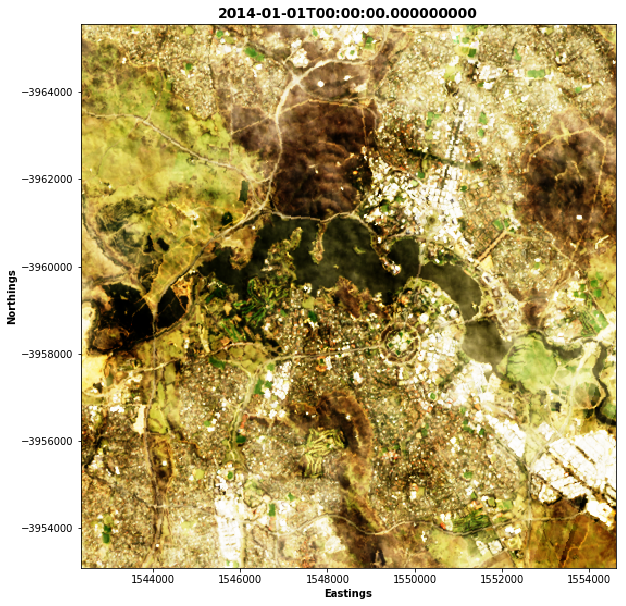

In [139]:
three_band_image(ds, bands = ['red', 'green', 'blue'], time = 0, contrast_enhance=True);